<a href="https://colab.research.google.com/github/Mohamed-derbeli/ML-for-maximum-power-point-tracking-prediction-in-PV-system/blob/main/ML_for_MPPT_prediction_in_PV_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Machine Learning For Maximum Power Point Tracking Prediction In PV System (Apache Spark)**

In [1]:
# Installing required packages
!pip install pyspark
!pip install findspark

import findspark
findspark.init()

     |████████████████████████████████| 281.4 MB 37 kB/s 
     |████████████████████████████████| 198 kB 45.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=b0651c9b7a93c1334c3e6fe5b6ff946c6c2c8f6e2c110b7fdc28b98306759ad8
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [5]:
# import tensorflow as tf
# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from tensorflow import keras
# from tensorflow.keras import models, layers, optimizers
from google.colab import files
# from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split
# import urllib.request
import io

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import LinearRegression

##Loading data into a Pandas DataFrame

In [6]:
uploaded = files.upload()  

data= io.BytesIO(uploaded['PV_data.xlsx'])
# read_file = csv.reader(codecs.iterdecode(data, 'utf-8'), delimiter=',')
df = pd.read_excel(data)

Saving PV_data.xlsx to PV_data.xlsx


In [8]:
df.head()

,Time,T_pv00,G_pv00,I_pv00,V_pv00,P_pv00,Time01,T_pv01,G_pv01,I_pv01,V_pv01,P_pv01,Time02,T_pv02,G_pv02,I_pv02,V_pv02,P_pv02,Time03,T_pv03,G_pv03,I_pv03,V_pv03,P_pv03,Time04,T_pv04,G_pv04,I_pv04,V_pv04,P_pv04,Time05,T_pv05,G_pv05,I_pv05,V_pv05,P_pv05,Time06,T_pv06,G_pv06,I_pv06,V_pv06,P_pv06,Time07,T_pv07,G_pv07,I_pv07,V_pv07,P_pv07,Time08,T_pv08,G_pv08,I_pv08,V_pv08,P_pv08,Time09,T_pv09,G_pv09,I_pv09,V_pv09,P_pv09,Time10,T_pv10,G_pv10,I_pv10,V_pv10,P_pv10
0,0.000000,38.822021,674.377441,0.272032,43.282867,11.774318,0.000000,6.131592,88.806152,0.866533,0.917970,0.795451,0.000000,7.083740,88.623047,0.270747,43.175272,11.689595,0.000000,21.334229,499.328613,0.279199,45.448010,12.689026,0.000000,27.697754,577.148438,5.622555,1.414828,7.954948,0.000000,35.172119,656.616211,0.274492,43.590099,11.965145,0.000000,38.822021,674.377441,0.272032,43.282867,11.774318,0.000000,39.234619,643.798828,0.265701,43.073828,11.444738,0.00,15.430908,108.764648,1.052417,0.991038,1.042986,0.000000,23.349609,263.305664,2.591401,1.101121,2.853447,0.000000,14.812012,427.734375,4.123004,1.178168,4.857590
1,0.009992,38.774414,673.645019,0.272101,43.283744,11.777559,0.009992,6.226807,89.904785,0.866292,0.917969,0.795229,0.009992,7.052002,88.073730,0.269853,43.174354,11.650719,0.009992,21.016846,496.032715,0.279199,45.447907,12.689028,0.009992,27.666016,577.148438,5.620805,1.415237,7.954770,0.009992,35.124512,656.799316,0.274967,43.591110,11.986113,0.009992,38.774414,673.645020,0.272101,43.283744,11.777559,0.099992,39.202881,642.883301,0.265629,43.076670,11.442393,0.03,15.510254,109.497070,1.052417,0.991695,1.043676,0.030000,23.333740,262.939453,2.591854,1.101946,2.856084,0.029995,14.859619,427.917480,4.122805,1.176492,4.850447
2,0.019984,38.790283,673.461914,0.272138,43.284969,11.779480,0.019984,6.147461,88.806152,0.865983,0.917935,0.794917,0.019984,7.052002,88.623047,0.268923,43.173432,11.610313,0.019984,21.397705,500.427246,0.280176,45.448064,12.733464,0.019984,27.650146,577.697754,5.619631,1.415052,7.952073,0.019984,35.108643,656.982422,0.275352,43.591364,12.002962,0.019984,38.790283,673.461914,0.272138,43.284969,11.779480,0.199985,39.187012,643.615723,0.265573,43.073666,11.439213,0.06,15.526123,109.680176,1.052703,0.992231,1.044524,0.060000,23.365479,263.122559,2.593142,1.102931,2.860055,0.059991,14.796143,427.734375,4.122881,1.176114,4.848978
3,0.029976,38.822021,674.011231,0.271990,43.285665,11.773278,0.029976,6.210938,89.355469,0.865765,0.917857,0.794649,0.029976,7.052002,88.073730,0.268053,43.172642,11.572558,0.029976,21.381836,500.244141,0.281924,45.448992,12.813141,0.029976,27.634277,577.514648,5.619608,1.414555,7.949241,0.029976,35.061035,657.165527,0.275497,43.591145,12.009229,0.029976,38.822021,674.011230,0.271990,43.285665,11.773278,0.299977,39.171143,643.981934,0.266636,43.069540,11.483899,0.09,15.557861,110.595703,1.052860,0.991691,1.044112,0.090000,23.397217,263.671875,2.592861,1.103698,2.861735,0.089986,14.653320,426.452637,4.123063,1.175789,4.847853
4,0.039968,38.615723,671.447754,0.271698,43.285783,11.760647,0.039968,6.099854,88.439941,0.865753,0.917700,0.794502,0.039968,7.147217,89.904785,0.267313,43.171866,11.540397,0.039968,21.318359,499.694824,0.284206,45.450287,12.917227,0.039968,27.634277,577.697754,5.620630,1.413682,7.945784,0.039968,35.092773,657.897949,0.275387,43.590456,12.004234,0.039968,38.615723,671.447754,0.271698,43.285783,11.760647,0.399969,39.218750,644.531250,0.268770,43.076558,11.577704,0.12,15.573730,109.863281,1.052867,0.992191,1.044645,0.120001,23.349609,262.939453,2.591746,1.102531,2.857481,0.119981,14.827881,428.649902,4.123685,1.176678,4.852250


In [76]:
# data for the maximum power point
url = 'https://github.com/Mohamed-derbeli/ML-for-maximum-power-point-tracking-prediction-in-PV-system/blob/main/PV_data.xlsx?raw=true'

In [77]:
df1 = pd.read_excel(url)
print(type(df1))
df1.head()

<class 'pandas.core.frame.DataFrame'>


,Pmax,Vmax,Imax,G,T
0,146.2333,38.3969,3.808466,426.2695,17.0813
1,149.2753,35.1044,4.252324,437.4390,18.0334
2,150.0502,38.0550,3.942983,446.4111,19.7314
3,154.4916,36.5494,4.226926,452.4536,20.3027
4,156.3199,36.4111,4.293194,459.2285,21.3342


#Data visualization 

In [75]:
# determination of x-axis and y-axis 
col=df.columns
X=[]   
Y=[]   
for i in range(0,len(col),6):
  index=col[i+4] 
  X.append(index)
  index=col[i+4] 
  X.append(index)
  index=col[i]
  X.append(index)
  index=col[i] 
  X.append(index)

  index=col[i+5] 
  Y.append(index)
  index=col[i+3] 
  Y.append(index)
  index=col[i+1]
  Y.append(index)
  index=col[i+2] 
  Y.append(index)
print(X)
print(Y)

['V_pv00', 'V_pv00', 'Time', 'Time', 'V_pv01', 'V_pv01', 'Time01', 'Time01', 'V_pv02', 'V_pv02', 'Time02', 'Time02', 'V_pv03', 'V_pv03', 'Time03', 'Time03', 'V_pv04', 'V_pv04', 'Time04', 'Time04', 'V_pv05', 'V_pv05', 'Time05', 'Time05', 'V_pv06', 'V_pv06', 'Time06', 'Time06', 'V_pv07', 'V_pv07', 'Time07', 'Time07', 'V_pv08', 'V_pv08', 'Time08', 'Time08', 'V_pv09', 'V_pv09', 'Time09', 'Time09', 'V_pv10', 'V_pv10', 'Time10', 'Time10']
['P_pv00', 'I_pv00', 'T_pv00', 'G_pv00', 'P_pv01', 'I_pv01', 'T_pv01', 'G_pv01', 'P_pv02', 'I_pv02', 'T_pv02', 'G_pv02', 'P_pv03', 'I_pv03', 'T_pv03', 'G_pv03', 'P_pv04', 'I_pv04', 'T_pv04', 'G_pv04', 'P_pv05', 'I_pv05', 'T_pv05', 'G_pv05', 'P_pv06', 'I_pv06', 'T_pv06', 'G_pv06', 'P_pv07', 'I_pv07', 'T_pv07', 'G_pv07', 'P_pv08', 'I_pv08', 'T_pv08', 'G_pv08', 'P_pv09', 'I_pv09', 'T_pv09', 'G_pv09', 'P_pv10', 'I_pv10', 'T_pv10', 'G_pv10']


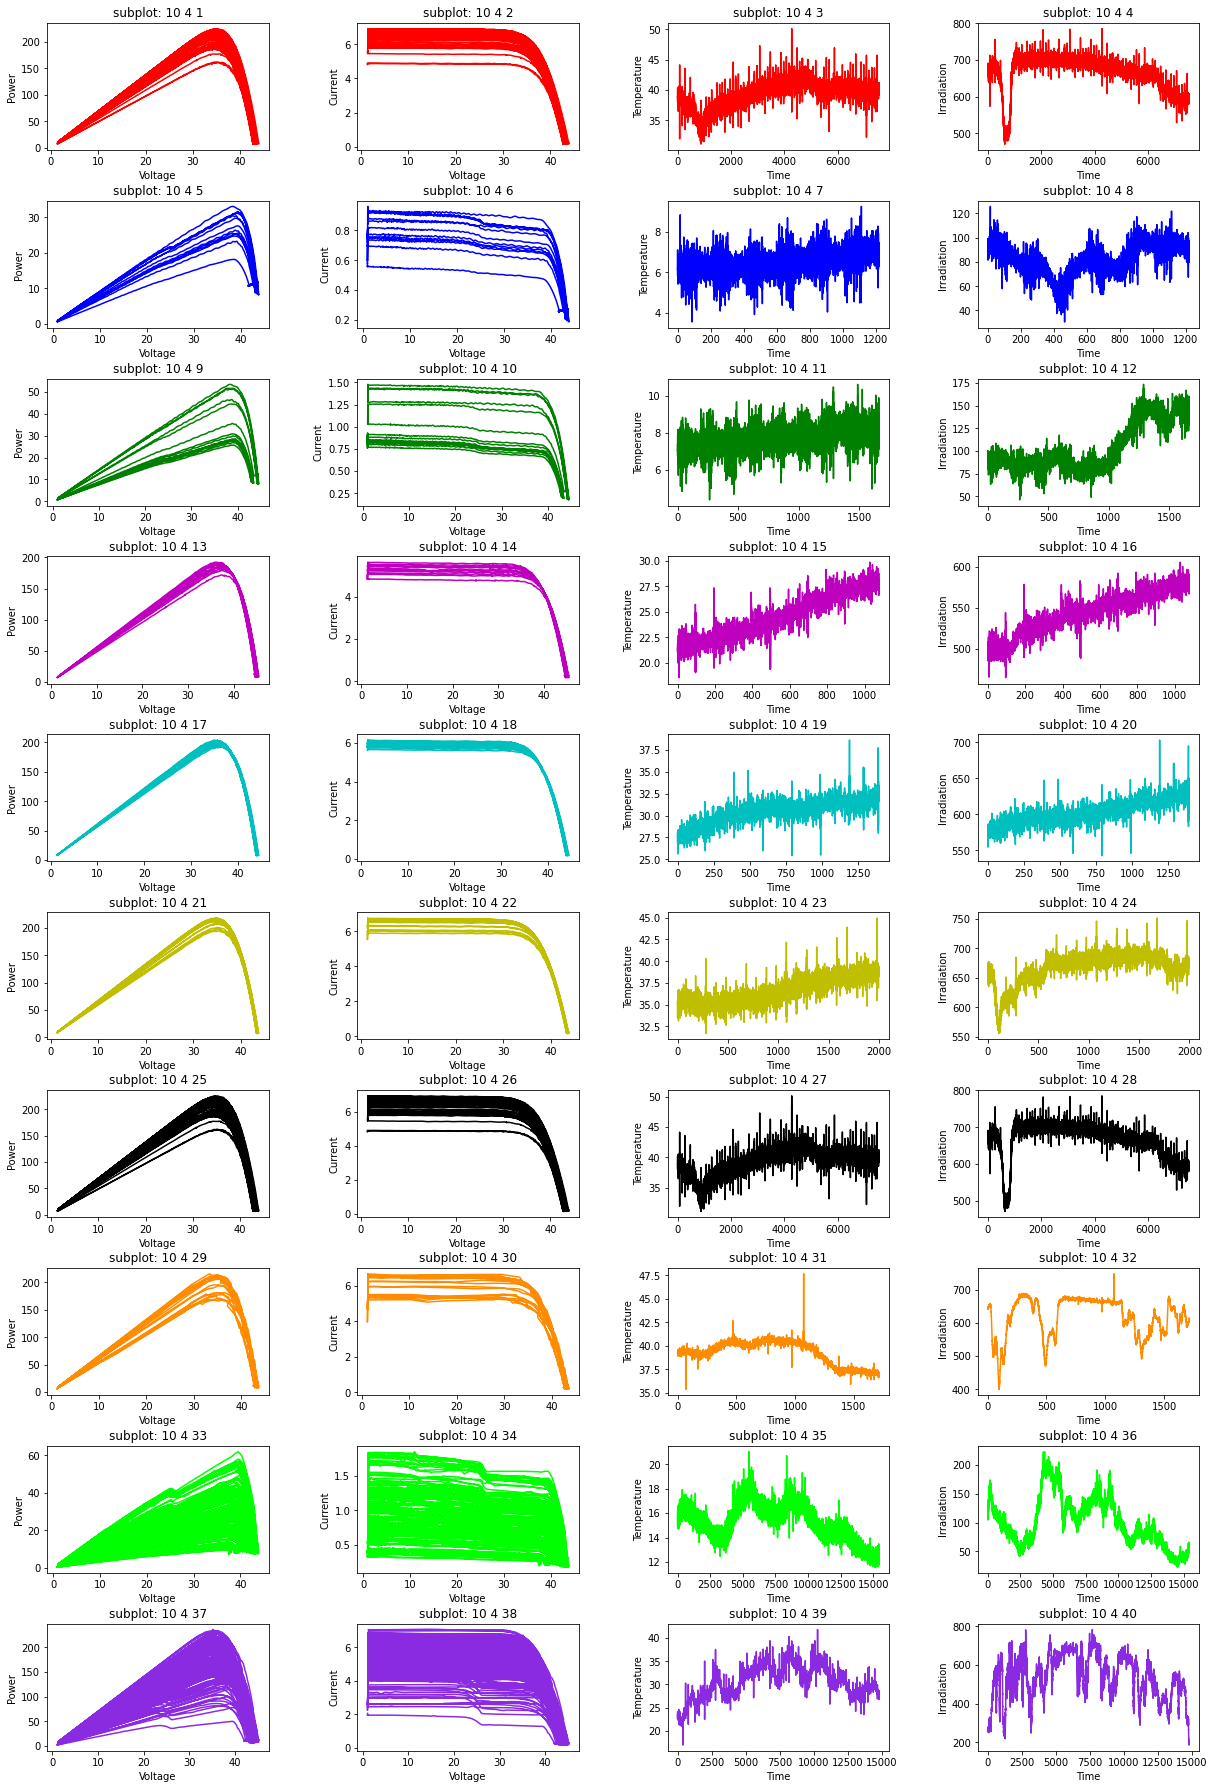

In [74]:
k1=['r','b','g','m','c','y','k','darkorange','lime','blueviolet',]                      # color
Xlab=['Voltage','Voltage','Time','Time']                                                # name of x-axis
Ylab=['Power','Current','Temperature','Irradiation']                                    # name of y-axis

a = 10  # number of rows
b = 4  # number of columns
c = 1  # initialize plot counter
itm=0
color=0


fig = plt.figure(figsize=(20,30))

# The following adjustment is needed to make space between the figures
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for i in range(10): 
  index=0 
  for j in range(4):
    plt.subplot(a, b, c)
    plt.title('subplot: {} {} {}'.format( a, b, c))
    plt.xlabel(Xlab[index])
    plt.ylabel(Ylab[index])
    plt.plot(df[X[itm]], df[Y[itm]],k1[color]) #,label=k2[index]
    c = c + 1
    itm= itm + 1
    index=index+1
  color=color+1
  
plt.show()

##Data visualisation

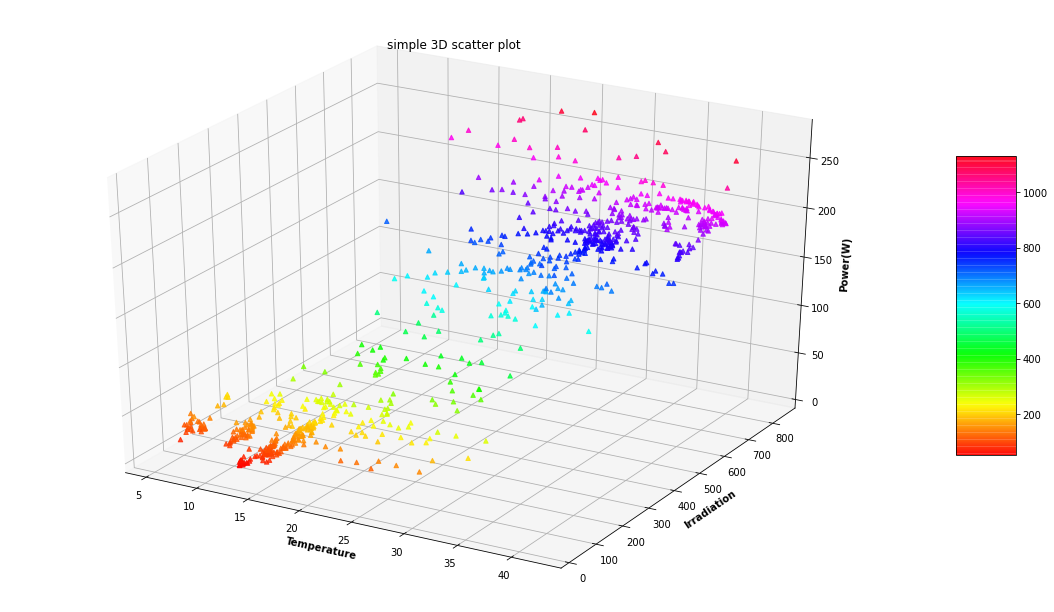

In [81]:
# Creating figure
fig = plt.figure(figsize = (20, 11))
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
 
# Creating color map
my_cmap = plt.get_cmap('hsv')
 
# Creating plot
x=df1['T']
y=df1['G']
z=df1['Pmax']
sctt = ax.scatter3D(x, y, z,
                    alpha = 0.8,
                    c = (x + y + z),
                    cmap = my_cmap,
                    marker ='^')
 
plt.title("simple 3D scatter plot")
ax.set_xlabel('Temperature', fontweight ='bold')
ax.set_ylabel('Irradiation', fontweight ='bold')
ax.set_zlabel('Power(W)', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
 
# show plot
plt.show()



# 2D
# df.plot(x ='Vmax', y='Pmax', kind = 'scatter')	
# df.plot(x ='Vmax', y='Imax', kind = 'scatter')	

# 3D without color
# threedee = plt.figure(figsize = (12, 8)).gca(projection='3d')
# threedee.scatter(df['T'], df['G'], df['Pmax'])
# threedee.set_xlabel('Temperature')
# threedee.set_ylabel('Irradiation')
# threedee.set_zlabel('Power(W)')
# plt.show()

#converting spark dataframe to pandas dataframe aiming to use matplotlib
# pdf = sdf.toPandas()

##Loading data into a Spark DataFrame

In [ ]:
# Creating a spark context class
sc = SparkContext()

# Creating a spark session
spark = SparkSession \
    .builder \
    .appName("Python Spark DataFrames") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

# Initialize Spark session
spark

# We use the `createDataFrame` function to load the data into a spark dataframe
sdf = spark.createDataFrame(df)

# Let us look at the schema of the loaded spark dataframe
sdf.printSchema()

root
 |-- Pmax: double (nullable = true)
 |-- Vmax: double (nullable = true)
 |-- Imax: double (nullable = true)
 |-- G: double (nullable = true)
 |-- T: double (nullable = true)



##Converting data frame columns into feature vectors

In [ ]:
assembler1 = VectorAssembler(
    inputCols=["T", "G"],
    outputCol="features1")

assembler2 = VectorAssembler(
    inputCols=["T", "Pmax"],
    outputCol="features2")

assembler3 = VectorAssembler(
    inputCols=["G", "Pmax"],
    outputCol="features3")

# Output voltage
output1 = assembler1.transform(sdf).select('features1','Vmax')
output2 = assembler2.transform(sdf).select('features2','Vmax')
output3 = assembler3.transform(sdf).select('features3','Vmax')

# Output Current
output4 = assembler1.transform(sdf).select('features1','Imax')
output5 = assembler2.transform(sdf).select('features2','Imax')
output6 = assembler3.transform(sdf).select('features3','Imax')


train1, test1 = output1.randomSplit([0.75, 0.25])
train2, test2 = output2.randomSplit([0.75, 0.25])
train3, test3 = output3.randomSplit([0.75, 0.25])
train4, test4 = output4.randomSplit([0.75, 0.25])
train5, test5 = output5.randomSplit([0.75, 0.25])
train6, test6 = output6.randomSplit([0.75, 0.25])

#stats

##1) Correlation
 Correlation means to find out the association between the two variables and Correlation coefficients are used to find out how strong is the relationship between the two variables.

### a) *Pearson* correlation

In [ ]:
corr1 = Correlation.corr(train1, "features1", method='pearson').head()
print("Pearson correlation matrix:\n" + str(corr1[0]))

corr2 = Correlation.corr(train2, "features2", method='pearson').head()
print("Pearson correlation matrix:\n" + str(corr2[0]))

corr3 = Correlation.corr(train3, "features3", method='pearson').head()
print("Pearson correlation matrix:\n" + str(corr3[0]))

corr4 = Correlation.corr(train4, "features1", method='pearson').head()
print("Pearson correlation matrix:\n" + str(corr4[0]))

corr5 = Correlation.corr(train5, "features2", method='pearson').head()
print("Pearson correlation matrix:\n" + str(corr5[0]))

corr6 = Correlation.corr(train6, "features3", method='pearson').head()
print("Pearson correlation matrix:\n" + str(corr6[0]))

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


Pearson correlation matrix:
DenseMatrix([[1.        , 0.86091847],
             [0.86091847, 1.        ]])
Pearson correlation matrix:
DenseMatrix([[1.       , 0.8367522],
             [0.8367522, 1.       ]])
Pearson correlation matrix:
DenseMatrix([[1.        , 0.99753296],
             [0.99753296, 1.        ]])
Pearson correlation matrix:
DenseMatrix([[1.        , 0.87275584],
             [0.87275584, 1.        ]])
Pearson correlation matrix:
DenseMatrix([[1.       , 0.8509512],
             [0.8509512, 1.       ]])
Pearson correlation matrix:
DenseMatrix([[1.        , 0.99760214],
             [0.99760214, 1.        ]])


### b) *Spearman* correlation

In [ ]:

corr1 = Correlation.corr(train1, "features1", method='spearman').head()
print("Spearman correlation matrix:\n" + str(corr1[0]))

corr2 = Correlation.corr(train2, "features2", method='spearman').head()
print("Spearman correlation matrix:\n" + str(corr2[0]))

corr3 = Correlation.corr(train3, "features3", method='spearman').head()
print("Spearman correlation matrix:\n" + str(corr3[0]))

corr4 = Correlation.corr(train4, "features1", method='spearman').head()
print("Spearman correlation matrix:\n" + str(corr4[0]))

corr5 = Correlation.corr(train5, "features2", method='spearman').head()
print("Spearman correlation matrix:\n" + str(corr5[0]))

corr6 = Correlation.corr(train6, "features3", method='spearman').head()
print("Spearman correlation matrix:\n" + str(corr6[0]))


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


Spearman correlation matrix:
DenseMatrix([[1.        , 0.83103683],
             [0.83103683, 1.        ]])
Spearman correlation matrix:
DenseMatrix([[1.        , 0.80940922],
             [0.80940922, 1.        ]])
Spearman correlation matrix:
DenseMatrix([[1.        , 0.99537789],
             [0.99537789, 1.        ]])
Spearman correlation matrix:
DenseMatrix([[1.        , 0.85386061],
             [0.85386061, 1.        ]])
Spearman correlation matrix:
DenseMatrix([[1.        , 0.82479965],
             [0.82479965, 1.        ]])
Spearman correlation matrix:
DenseMatrix([[1.        , 0.99521232],
             [0.99521232, 1.        ]])


##2) Normalization